# [Evaluating and Improving Models](https://campus.datacamp.com/courses/introduction-to-deep-learning-with-pytorch/evaluating-and-improving-models?ex=1)

Fourth chapter in the Introduction to Deep Learning with PyTorch DataCamp course.

##  1 - Layer Initialization and Transfer Learning

* Data normalization scales input features for stability.

* The weights of a linear layer are also initialized to small values.

In [72]:
import torch.nn as nn

layer = nn.Linear( 64, 128)
print(layer.weight.min(), layer.weight.max(), '\n')

# Another way to initialize weigths, range between 0 to 1:
nn.init.uniform_(layer.weight)
print(layer.weight.min(), layer.weight.max())

tensor(-0.1250, grad_fn=<MinBackward1>) tensor(0.1250, grad_fn=<MaxBackward1>) 

tensor(2.6822e-05, grad_fn=<MinBackward1>) tensor(1.0000, grad_fn=<MaxBackward1>)


* Transfer learning: Reusing a model trained on a first task for a second similar task.

In [ ]:
# Transfer learning
import torch 

torch.save(layer, 'layer.pth')
new_layer = torch.load('layer.pth', weights_only=False)
print(new_layer)

Linear(in_features=64, out_features=128, bias=True)


* **Fine-tunning**: A type of transfer learning. Load weights from a previously trained model, but train the model with a smaller learning rate.

* Train part of the network (freeze some of them).

* Rule of thumb: freeze early layers of network and fine-tune layers colser to output layer.

In [74]:
model = nn.Sequential(
    nn.Linear(3, 10),
    nn.Linear(10, 2)
)

for name, param in model.named_parameters():
    if name == '0.weight':
        param.requires_grad = False

Fine-tuning process:

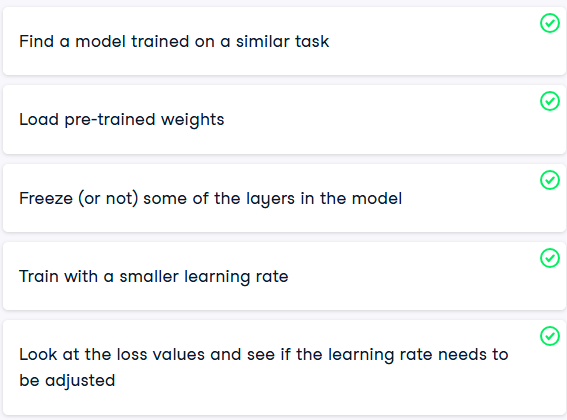

## 2 - Evaluating Model Performance

Typically split the dataset into three subsets: 

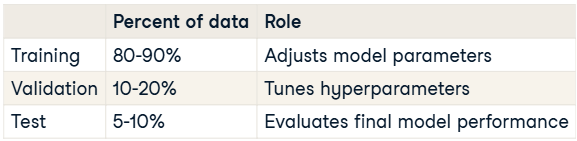

### 2.1 - Training Loss

* Calculating training loss, for each epoch:
    - Sum the loss across all batches in the dataloader.
    - Compute the mean training loss at the end of the epoch.

In [75]:
import torch.nn as nn
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np

# Inputs
X_train = np.array([
    [0.5, 3.4, 6.7],
    [1.2, 5.0, 7.3],
    [34.2, 44.0, 12.3],
    [0.4, 6.7, 2.2],
    [20.3, 1.1, 5.8]
])

# Labels
y_train = np.array([1.3, 4.5, 3.4, 2.2, 4.0])

# 1) Create a model
layer1 = nn.Linear(3, 5)
nn.init.uniform_(layer1.weight)

layer2 = nn.Linear(5, 10)
nn.init.uniform_(layer2.weight)

model = nn.Sequential(
    layer1,
    nn.ReLU(),
    layer2,
    nn.ReLU(),
    nn.Linear(10, 1),
)

# 2) Choose a loss function
criterion = MSELoss()

# 3) Define a dataset
train_dataset = TensorDataset(
    torch.tensor(X_train).float(),
    torch.tensor(y_train).float()
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True
)

# 4) Set an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [76]:
# 5) Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for data in train_dataloader:
        optimizer.zero_grad() # Reset gradients

        # Get feature an target from the dataloader
        feature, target = data

        # Run a forward pass
        pred = model(feature)

        # Compute loss
        loss = criterion(pred, target.unsqueeze(1))

        # Backpropagation
        loss.backward() # Compute gradientes
        optimizer.step() # Update weights

        # Calculate and sum the loss
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(avg_epoch_loss)


10115.936097656688
575.227415005366
12.284591515858969
10.72305679321289
9.012223641077677
11.232760429382324
11.806049982706705
11.683208306630453
11.55951992670695
10.756024042765299


### 2.2 - Evaluation Loop

In [82]:
# Inputs
X_validation = np.array([
    [0.9, 6.4, 0.7],
    [1.7, 3.0, 0.3],
    [21.2, 12.0, 0.3],

])

# Labels
y_validation = np.array([3.0, 1.9, 0.1])

validation_dataset = TensorDataset(
    torch.tensor(X_validation).float(),
    torch.tensor(y_validation).float()
)

validation_dataloader = DataLoader(
    dataset=validation_dataset,
    batch_size=2,
    shuffle=True
)

# Validation loop
for epoch in range(num_epochs):
    model.eval()
    validation_epoch_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validation_dataloader:
            # Run forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels.unsqueeze(1))
            validation_epoch_loss += loss.item()

    avg_epoch_loss = validation_epoch_loss / len(validation_dataloader)
    print(avg_epoch_loss)
    model.train()

2.762580070644617
2.762580070644617
3.513514280319214
4.769918739795685
2.762580070644617
4.769918739795685
3.513514280319214
3.513514280319214
4.769918739795685
2.762580070644617


### 2.3 - Torchmetrics

* TorchMetrics is a collection of 100+ PyTorch metrics implementations and an easy-to-use API to create custom metrics. [Lightning AI](https://lightning.ai/docs/torchmetrics/stable/pages/quickstart.html).

* [All Torchmetrics](https://lightning.ai/docs/torchmetrics/stable/all-metrics.html)

In [97]:
from torchmetrics.regression import MeanSquaredError
metric = MeanSquaredError()

for epoch in range(3):
    model.eval()
    print(f'Epoch: {epoch}')
    with torch.no_grad():
        for features, target in validation_dataloader:
            print('Features:', features)
            print('Target:', target)
            prediction = model(features)
            print('Prediction:', prediction, '\n')
            metric.update(prediction, target.unsqueeze(1))
    mse = metric.compute()
    print(f'MSE Epoch {epoch} = {mse} \n')
    metric.reset()
    model.train()

Epoch: 0
Features: tensor([[21.2000, 12.0000,  0.3000],
        [ 1.7000,  3.0000,  0.3000]])
Target: tensor([0.1000, 1.9000])
Prediction: tensor([[0.1656],
        [0.1656]]) 

Features: tensor([[0.9000, 6.4000, 0.7000]])
Target: tensor([3.])
Prediction: tensor([[0.1656]]) 

MSE Epoch 0 = 3.68200421333313 

Epoch: 1
Features: tensor([[21.2000, 12.0000,  0.3000],
        [ 1.7000,  3.0000,  0.3000]])
Target: tensor([0.1000, 1.9000])
Prediction: tensor([[0.1656],
        [0.1656]]) 

Features: tensor([[0.9000, 6.4000, 0.7000]])
Target: tensor([3.])
Prediction: tensor([[0.1656]]) 

MSE Epoch 1 = 3.68200421333313 

Epoch: 2
Features: tensor([[21.2000, 12.0000,  0.3000],
        [ 0.9000,  6.4000,  0.7000]])
Target: tensor([0.1000, 3.0000])
Prediction: tensor([[0.1656],
        [0.1656]]) 

Features: tensor([[1.7000, 3.0000, 0.3000]])
Target: tensor([1.9000])
Prediction: tensor([[0.1656]]) 

MSE Epoch 2 = 3.68200421333313 



## 3 - Avoid Overfitting

* Overfitting: the model does not generalize to unseen data. Possible causes:

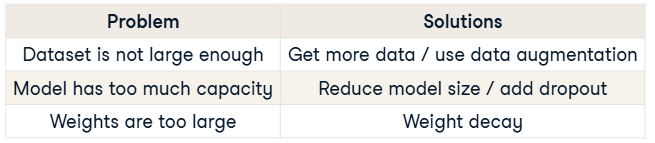

### 3.1 - Dropout Layer

* Regularization using a dropout layer: randomly deactivates a fraction of neuron during training, preventing the model from becoming too dependent on specific features.

* Drop is added after the activation function.

In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Dropout(p=0.5)
)

# In this example, 50% of neurons are dropped
features = torch.randn((1, 8))
print(model(features))

tensor([[0.0000, 1.3127, 0.0000, 0.0000]], grad_fn=<MulBackward0>)


### 3.2 - Weight Decay

In [2]:
import torch.optim as optim

optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.99,
    weight_decay=0.0001 # Typically a small value
)

Weight decay add a penalty to the loss function, encouraging smaller weights and helping the model generalize better. During backpropagation, this penalty is substrated from the gradien, preventing excessive weight growth

### 3.3 - Data Augmentation

Expand datasets artificially using data augmentation

## 4 - Improving Model Performance

* 1) Create a model that can overfit the training set.

* 2) Reduce overfitting ot increase performance on the validation set.

* 3) Fine-tune the hyperparametersto ensure achieve the best possible performance.